The purpose of this calculation is to reproduce the results from [Asuncion et al., Philippine Journal of Science, 2019](https://github.com/pgniewko/conotoxins/tree/master/papers/ASA.PJS.2019.pdf). The data used in this work is downloaded from the [ConoServer](http://www.conoserver.org/?page=download) (access data: 11/18/19). Instead of using [protr](https://cran.r-project.org/web/packages/protr/vignettes/protr.html) package for peptides featurizaion, I use a Python implementation [pydpi](https://pypi.org/project/pydpi/#files). `pydpi` was originally implemented in Python 2, so to make it work with my code I have [reimplemented](https://github.com/pgniewko/conotoxins/tree/master/external/py3dpi) it in Python 3. Other tools also exist, e.g. [iFeature](https://github.com/Superzchen/iFeature/) by [Chen et al., Bioinformatics 2018](https://github.com/pgniewko/conotoxins/tree/master/papers/iFeature.2018.pdf).

1. Only about 1% of all conopeptides have structural and functional data 
2. The primery goal is to explore the data and not to do the prediction - the amount of data is so small that it's more for fun than real science. 
3. I think that 94.6% accuracy with 3 classes (sodium, calcium, and potassium channels) classes about 150 samples clearly looks like an overtraining (Wu et al 2016). The paper did a feature selection and it bears a possibility of randomly choosing a small number of featrues that accidently correlate well - thoudsands of features, c.a. 150 samples.
4. The paper I'm trying to reproduce deciden on the number of PCs such that it explain 99% of the data variability. PCs=137
5. How can I use PSSM? Actually write about the weakness of the approach if the homology is difficult to get, the method is not very useful. 
6. Homology based models.
7. Make a table with references to the known benchmarks (Table 1).
8. write which features were used in this work
9. Criticize the review paper for their proposal for features selection. If there is a small number of datapoints this can tick us if we don't use y-radomization techqniques. 

In [1]:
import sys
import xml.etree.ElementTree as ET


from toxin import Toxin
from experiment import Experiment


import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
from scipy import stats
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

First we read and parse XML file. Then we create a toxin object for all available data.

In [2]:
db_file = "../data/conoserver/conoserver_protein.xml"
tree = ET.parse(db_file)
root = tree.getroot()

toxins = []
for entry in root.iter('entry'):
    pid = entry.find('id').text if entry.find('id') is not None else None
    seq = entry.find('sequence').text if entry.find('sequence') is not None else "None"
    name = entry.find('name').text if entry.find('name') is not None else "None"
    toxin_class =  entry.find('class').text if entry.find('class') is not None else "None"
    organism = entry.find('organismLatin').text if entry.find('organismLatin') is not None else "None"
    geneSuperfamily = entry.find('geneSuperfamily').text if entry.find('geneSuperfamily') is not None else "None"
    cysteineFramewrok = entry.find('cysteineFramewrok').text if entry.find('cysteineFramewrok') is not None else "None"
    pharmacologicalFamily = entry.find('pharmacologicalFamily').text if entry.find('pharmacologicalFamily') is not None else "None"
    isoelecticPoint = entry.find('isoelecticPoint').text if entry.find('isoelecticPoint') is not None else "None"
    
    toxin = Toxin(pid,
                  seq,
                  name,
                  toxin_class,
                  organism,
                  geneSuperfamily,
                  cysteineFramewrok,
                  pharmacologicalFamily, 
                  isoelecticPoint)
    
    mods = entry.find('sequenceModifications')
    if mods is not None:
        for mod in mods.iter('modification'):
            toxin.add_modification( mod.attrib )
    
    toxin._clean_seq()
    toxins.append(toxin)

I tried to ways of building the dataset. The first one was an automated parsing of the XML file, given the specs provied in the paper. The second approach was to take the protein ids, sequences and molecular targets from the [paper](). I noticed that the data in the paper differes (moslty for $\alpha$-toxins) from the paper. It seems that the data used in the paper was manually curated. Some toxins that don't have specified target, were included wheres some peptides that have well defined target were exluded from the dataset. Moreover, 4 peptides that were inlcuded in the original study, is missing in the data downlaoded from ConoServer. It due to the fact, that for these 4 cases, a precursor is ginve not an actuall mature peptide. To be able to work with these cases, the following changes weremade to their sequneces:

|Protein ID| Position  | Mature amino-acid | Original amino-acid|        
|------|----|---|----|   
|P06822| 2  | X | W  |    
|P06822| 6  | X | P  |    
|P06822| 24 | X | C  |
|P07401| 2  | X | E  |    
|P07401| 3  | X | E  |    
|P07401| 7  | X | E  |
|P07401| 10 | X | "" |
|P07646| 4  | X | P  |
|P07646| 10 | X | P  |
|P07647| 4  | X | P  |  
|P07647| 10 | X | P  |

For the other amino-acids, the sequence was changed to the original sequence using information contained in `sequenceModifications` field.

In [3]:
experiment = Experiment(toxins, min_val=8)
if False:
    experiment.prepare_experiment()
else:
    experiment.experiment_from_file('../data/ASA.PJS.2019.txt')

data, labels, labels_map = experiment.get_data()   

Can't find protein with id P06822. Createing a new object with seq: GWCGDPGATCGKLRLYCCSGFCDCYTKTCKDKSSA and class: sodium
Can't find protein with id P07401. Createing a new object with seq: GEEEYSEAI and class: NMDARs
Can't find protein with id P07646. Createing a new object with seq: CKPPGSKCSPSMRDCCTTCISYTKRCRKYY and class: calcium
Can't find protein with id P07647. Createing a new object with seq: CKPPGSKCSPSMRDCCTTCISYTKRCRKYYN and class: calcium
GCPWDPWC
Skipping P01270 protein, with a sequence: GCPWDPWC
GCPWDPWC
Skipping P01272 protein, with a sequence: GCPWDPWC
GDCPKPWC
Skipping P01309 protein, with a sequence: GDCPKPWC


Now, the data is featurized we want to turn the features into Z-scores. However, we have a sample of only 153 sequences, and some of the peptides are failry small and many features are absent in all the studied cases. Thus to avoid any numerical issues and exceptions, I removed all the empty columns. Once the empty columns were removed I transformed it into Z-scores, and then transormed into PC spaces and retained only 100 most important one.

** In the original work 137 features were used and there are only c.a. 150 samples which means that these results can't be seious. We decided to go with 10 (i.e. number of features being at least an order of magnitde lower than the number of samples).

In [4]:
data_cleaded = []
for i in range(data.shape[1]):
    std= np.std(data[:,i])
    if std != 0:
        data_cleaded.append(data[:,i])
data_cleaded = np.array(data_cleaded)
data_cleaded = data_cleaded.T

zscores = stats.zscore(data_cleaded, axis=0, ddof=1)
pca = PCA(n_components=100)
zscores_pca = pca.fit_transform(zscores)

First I plot the amount of data variation explained by a certain number of Principal Components.

Text(0, 0.5, 'X 2')

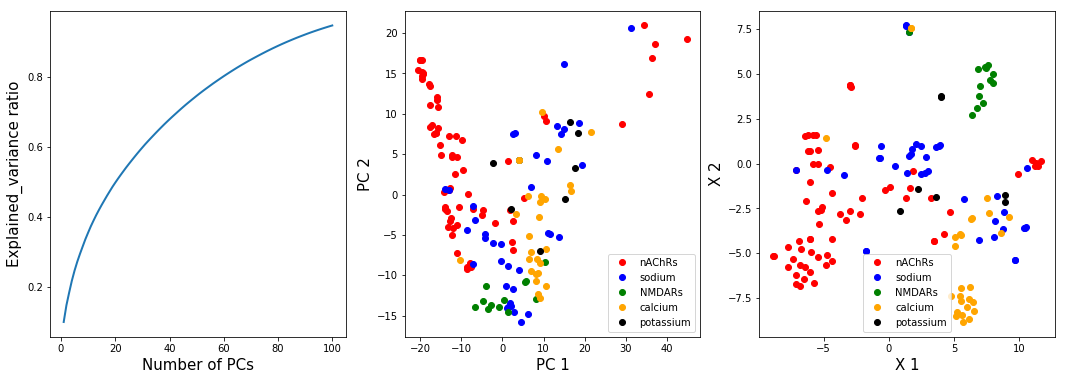

<Figure size 504x504 with 0 Axes>

In [5]:
fig, axis = plt.subplots(1, 3, figsize=(18,6))

ax1 = axis[0]
ax2 = axis[1]
ax3 = axis[2]


y = np.cumsum(pca.explained_variance_ratio_)
x = [i+1 for i in range(len(y))]

fig = plt.figure(figsize=(7, 7))
ax1.plot(x, y, lw=2)
ax1.set_xlabel('Number of PCs', fontsize=15)
ax1.set_ylabel('Explained_variance ratio', fontsize=15)


# Each class correspond to the molecular target
color_map = {0:'red', 1:'blue', 2:'green', 3:'orange', 4:'black'}

for label, color in color_map.items():
    x = [zscores_pca[i, 0] for i in range(len(labels)) if labels[i] == label]
    y = [zscores_pca[i, 1] for i in range(len(labels)) if labels[i] == label]
    ax2.plot(x, y, 'o', c=color, label=labels_map[label])
ax2.legend()
ax2.set_xlabel("PC 1", fontsize=15)
ax2.set_ylabel("PC 2", fontsize=15)

# Embed first 10 PCs. 
X_embedded = TSNE(n_components=2).fit_transform(zscores_pca[:,0:10])

for label, color in color_map.items():
    x = [X_embedded[i,0] for i in range(len(labels)) if labels[i] == label]
    y = [X_embedded[i,1] for i in range(len(labels)) if labels[i] == label]
    ax3.plot(x, y, 'o', c=color, label=labels_map[label])
ax3.legend()
ax3.set_xlabel("X 1", fontsize=15)
ax3.set_ylabel("X 2", fontsize=15)

# Embedding all the data

Get the experiment for all the data: annotated and unannotated.

In [29]:
experiment_all_data = Experiment(toxins, min_val=1)
experiment_all_data.prepare_experiment(strict=False)
data_all, labels_all, labels_map_all = experiment_all_data.get_data() 

CCCC
Skipping P00134 protein, with a sequence: CCCC
CCCC
Skipping P00135 protein, with a sequence: CCCC
CCCC
Skipping P00136 protein, with a sequence: CCCC
DCCRRCTLIC
Skipping P00141 protein, with a sequence: DCCRRCTLIC
GCCSDRCHQC
Skipping P00145 protein, with a sequence: GCCSDRCHQC
GCCHACGRHC
Skipping P00148 protein, with a sequence: GCCHACGRHC
CCNNACVHRC
Skipping P00151 protein, with a sequence: CCNNACVHRC
GCCSRCAVLC
Skipping P00153 protein, with a sequence: GCCSRCAVLC
ACCACFARCL
Skipping P00189 protein, with a sequence: ACCACFARCL
NACCCAICL
Skipping P00190 protein, with a sequence: NACCCAICL
GCCNVCC
Skipping P00239 protein, with a sequence: GCCNVCC
GCCNSCTCS
Skipping P00242 protein, with a sequence: GCCNSCTCS
CCSNTCTGC
Skipping P00243 protein, with a sequence: CCSNTCTGC
CCANICNTGC
Skipping P00244 protein, with a sequence: CCANICNTGC
CCNNTCTGC
Skipping P00245 protein, with a sequence: CCNNTCTGC
CCSNVCTGC
Skipping P00246 protein, with a sequence: CCSNVCTGC
GCCNCGASTC
Skipping P00249 p

PCRKTM
Skipping P02382 protein, with a sequence: PCRKTM
MYDCCT
Skipping P02384 protein, with a sequence: MYDCCT
Error......
Please input a correct protein.
Skipping P02390 protein, with a sequence: ZTWLVPSTITTCCGYDPGTMCPTCMCDNTCKPKPKKSGRRND
GRRNH
Skipping P02406 protein, with a sequence: GRRNH
Error......
Please input a correct protein.
Skipping P02408 protein, with a sequence: ZTWLVPSTITTCCGYDPGTMCPTCMCDNTCKPKPKKS
GRRND
Skipping P02410 protein, with a sequence: GRRND
CCPACGC
Skipping P02425 protein, with a sequence: CCPACGC
CCCCCC
Skipping P02433 protein, with a sequence: CCCCCC
CCCC
Skipping P02434 protein, with a sequence: CCCC
CCCC
Skipping P02435 protein, with a sequence: CCCC
GRRNH
Skipping P02447 protein, with a sequence: GRRNH
Error......
Please input a correct protein.
Skipping P02449 protein, with a sequence: ZTWLVPSTITTCCGYDPGTMCPTCMCDNTCKPKPKKS
GRRND
Skipping P02451 protein, with a sequence: GRRND
CCPACGC
Skipping P02466 protein, with a sequence: CCPACGC
CCCCCC
Skipping P02

(6062, 1880)


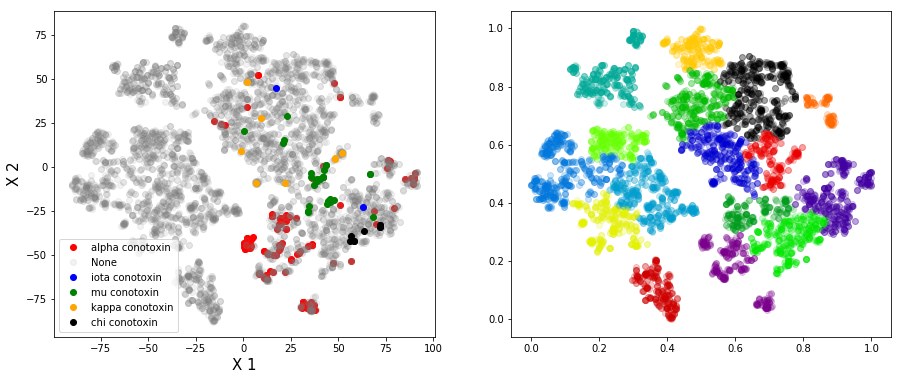

In [75]:
# Embed first 10 PCs. 
X_embedded = TSNE(n_components=2).fit_transform(zscores_pca_all[:, 0:10])


fig, axis = plt.subplots(1, 2, figsize=(15,6))

ax1 = axis[0]
ax2 = axis[1]


color_map_all = {0:'red', 1:'grey', 2:'blue', 3:'green', 4:'orange', 5:'black'}

data_cleaded_all = []
for i in range(data_all.shape[1]):
    std= np.std(data_all[:,i])
    if std != 0:
        data_cleaded_all.append(data_all[:,i])
data_cleaded_all = np.array(data_cleaded_all)
data_cleaded_all = data_cleaded_all.T

print(data_cleaded_all.shape)

zscores_all = stats.zscore(data_cleaded_all, axis=0, ddof=1)
pca_all = PCA(n_components=100)
zscores_pca_all = pca.fit_transform(zscores_all)

for label, color in color_map_all.items():
    alpha = 1.0
    x = [X_embedded[i,0] for i in range(len(labels_all)) if labels_all[i] == label]
    y = [X_embedded[i,1] for i in range(len(labels_all)) if labels_all[i] == label]
    if len(x) > 0:
        if labels_map_all[label] == 'None':
            alpha = 0.1
        ax1.plot(x, y, 'o', c=color, label=labels_map_all[label], alpha=alpha)
ax1.legend()
ax1.set_xlabel("X 1", fontsize=15)
ax1.set_ylabel("X 2", fontsize=15)

## CLUSTERING
X_red = X_embedded[:,0:2]
clustering = AgglomerativeClustering(n_clusters=16).fit(X_red)

labels = clustering.labels_
x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
X_red = (X_red - x_min) / (x_max - x_min)

for i in range(X_red.shape[0]):
    ax2.scatter(X_red[i, 0], X_red[i, 1],
                color=plt.cm.nipy_spectral(labels[i] / 16.), alpha=0.2)

# Statistics 

The statistics are calculated for the  Asuncion et al. paper.     
(TODO: Add error bars and 95% confidence intervals)

### Global Metrics

In [7]:
X = zscores_pca[:,0:50]
y = labels
y_true = []
y_pred = []
kf = KFold(n_splits=50, random_state=42, shuffle=True )
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = OneVsRestClassifier(LogisticRegression(solver='newton-cg')).fit(X_train, y_train)
    y_pred += list(clf.predict(X_test))
    y_true += list(y_test)

In [51]:
print("Accuracy = ", accuracy_score(y_true, y_pred))
print("F1-score = ", f1_score(y_true, y_pred, average='weighted'))
print("Precision = ", precision_score(y_true, y_pred,average='weighted'))
print("Recall = ", recall_score(y_true, y_pred, average='weighted'))
print("Cohen kappa =", cohen_kappa_score(y_true, y_pred))

Accuracy =  0.869281045751634
F1-score =  0.8694395260891424
Precision =  0.8732959850606908
Recall =  0.869281045751634
Cohen kappa = 0.811367279003822


### Per class statistics

In [52]:
columns = [labels_map[label] for label in color_map.keys()]
columns = [labels_map[label] for label in color_map.keys()]
metrics = ['Precision', 'Recalls', 'F-score', 'Support']
df = pd.DataFrame(mat, columns=columns, index = metrics)
df

,nAChRs,sodium,NMDARs,calcium,potassium
Precision,0.942857,0.750000,1.000000,0.777778,1.000000
Recalls,0.970588,0.789474,0.846154,0.777778,0.714286
F-score,0.956522,0.769231,0.916667,0.777778,0.833333
Support,68.000000,38.000000,13.000000,27.000000,7.000000


### Confusion matrix

In [50]:
df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=columns, index=columns)
df_cm

,nAChRs,sodium,NMDARs,calcium,potassium
nAChRs,66,2,0,0,0
sodium,3,30,0,5,0
NMDARs,0,1,11,1,0
calcium,0,6,0,21,0
potassium,1,1,0,0,5
